In [1]:
import sys
import os
import glob
import pandas as pd
import soundfile as sf
import numpy as np
import pickle
from sklearn import preprocessing
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import librosa
import torch
from torch.utils.data import DataLoader
from HSTBC.Datasets.SimpleDataset import SimpleDataset
import torch.nn.functional as F
from torch.utils.data import random_split
import torch.nn as nn

c:\Users\Thats\miniconda3\envs\ani\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Create a dictionary containing file path and its label ##

In [2]:
file_to_label_dict = {}

In [9]:
# Modified from:

"""
Created by Francisco Bravo Sanchez July 2021
This scripts reads the NIPS4B wav files and splits them according to the
csv annotations from NIPS4Bplus (Morfi V, Bas Y, Pamula H, Glotin H,
Stowell D. 2019. NIPS4Bplus: a richly annotated birdsong audio dataset.
PeerJ Comput. Sci. 5:e223 http://doi.org/10.7717/peerj-cs.223)

NIPS4B wav files:
http://sabiod.univ-tln.fr/nips4b/media/birds/NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV.tar.gz

NIPS4Bplus annotations:
https://doi.org/10.6084/m9.figshare.6798548

Instructions
https://github.com/fbravosanchez/NIPS4Bplus#readme
"""

import sys
import os
import glob
import pandas as pd
import soundfile as sf
import numpy as np


#Set directories
#path to NIPS4B_BIRD wav files
wav_path = "Data\\wav\\train"
#path to NIPS4Bplus csv annotation files
csv_path = "Data\\temporal_annotations_nips4b"
#output path for generated cut files
output_path = "Data\\cutfiles"

if not os.path.exists(output_path):
    os.makedirs(output_path)


#read csv label file list
lbl_files = pd.DataFrame(glob.glob(os.path.join(csv_path , '')+ '*.csv'))
lbl_files.columns = ['csv']
lbl_files['wav'] = 'nips4b_birds_trainfile' + lbl_files['csv'].str[-7:-4]


#process by csv file
for i, j in lbl_files.iterrows():

    #skip empty files
    try:
        k = pd.read_csv(j['csv'], header=None)
        tags = True
    except pd.errors.EmptyDataError:
        tags = False

    #for each valid csv file process wavefile
    if tags:
        [signal, fs] = sf.read(os.path.join(wav_path , '') + j['wav'] + '.wav')
        signal = signal.astype(np.float64)
        # print(signal.shape)

        # Signal normalization
        signal = signal/np.abs(np.max(signal))

        #cut signal according to tag
        for l, m in k.iterrows():
            beg_sig = int(m[0]*fs)
            end_sig = int((m[0]+m[1])*fs)
            signal_cut = signal[beg_sig:end_sig]

            # Save cut signal as a new wavefile
            file_out = os.path.join(output_path, '') + str(j['wav']) +'_'+ str(l) + '.wav'
            sf.write(file_out, signal_cut, fs)


            # Add to dictionary if it is a bird call            
            label = m[2]
            if "_call" in label or "_song" in label:
                file_to_label_dict[file_out] = label


KeyboardInterrupt: 

Pickle the file->label dictionary so we don't have to run that again
**NOTE: v1 version of the dict has _call and _song specifications removed, v2 has them still in (e.g. in v1 you would have Erirub and Erirub, in v2 you would have Erirub_call, Erirub_song)**

In [5]:
import pickle

with open('./pickles/filelabeldictv2.pkl', 'wb') as fp:
    pickle.dump(file_to_label_dict, fp)
    print("Pickle Successful")

Pickle Successful


Load pickle

In [3]:
with open('./pickles/filelabeldictv2.pkl', 'rb') as fp:
    file_to_label_dict = pickle.load(fp)
    print("Pickle loaded")

Pickle loaded


# Create dataset from file label dict #

### Convert labels into class indices ###

In [4]:
lables_int = None

In [10]:
labels = list(file_to_label_dict.values())
le = preprocessing.LabelEncoder()
le.fit(labels)
labels_int = le.transform(labels)

keys = list(file_to_label_dict.keys())

file_to_class_int = dict(zip(keys, labels_int))

Pickle Labels_int

In [101]:
with open('./pickles/labels_int.pkl', 'wb') as fp:
    pickle.dump(labels_int, fp)
    print("Pickle Successful")

Pickle Successful


In [5]:
with open('./pickles/labels_int.pkl', 'rb') as fp:
    labels_int = pickle.load(fp)
    print("Pickle loaded")

Pickle loaded


In [6]:
one_hot_labels = None

In [27]:
num_classes = np.max(labels_int)
label_binarizer = preprocessing.LabelBinarizer()
label_binarizer.fit(range(max(labels_int)+1))
one_hot_labels = label_binarizer.transform(labels_int)

[ 3 20 20 ... 57 57 57]
[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]


Pickling of one hots

In [28]:
with open('./pickles/one_hot.pkl', 'wb') as fp:
    pickle.dump(one_hot_labels, fp)
    print("Pickle Successful")

Pickle Successful


In [7]:
with open('./pickles/one_hot.pkl', 'rb') as fp:
    one_hot_labels = pickle.load(fp)
    print("Pickle loaded")

Pickle loaded


## Convert audio files to Mel-frequency Cepstral Coefficients (MFCC) images to use for classification ##

In [93]:
baseline_features = []

In [11]:
print(len(keys))
print(len(labels_int))

5459
5459


In [94]:
'''
Taken from Microsoft's audio classification tutorials: https://learn.microsoft.com/en-us/training/modules/intro-audio-classification-pytorch/3-visualizations-transforms
'''

import torchaudio
import matplotlib.pyplot as plt

total_keys = len(keys)
curr_key = 1
for file, label in zip(keys, labels):
# audio file is decoded on the fly
    print(str(curr_key) + "/" + str(total_keys))
    # os.makedirs(f'./HSTBC/Datasets/data/mfcc_spectrograms/{label}/', mode=0o777, exist_ok=True)

    waveform, sample_rate = torchaudio.load(file)
    while waveform.shape[1] < 200:
        waveform = torch.cat([waveform, waveform], dim=1)
        print("Catting")
    print(waveform.shape)
    
    mfcc_spectrogram = torchaudio.transforms.MFCC(sample_rate= sample_rate)(waveform)
    print(mfcc_spectrogram.shape)
    baseline_features.append(mfcc_spectrogram)
    # baseline_features.append(mfcc_spectrogram.log2()[0,:,:].numpy())
    # print(mfcc_spectrogram.log2()[0,:,:].numpy().shape)

    curr_key+=1
    # plt.figure()
    # fig1 = plt.gcf()
    # plt.imshow(mfcc_spectrogram.log2()[0,:,:].numpy(), cmap='viridis')
    # plt.draw()
    # fig1.savefig(f'./HSTBC/Datasets/data/mfcc_spectrograms/{label}/spec_img{file}.png', dpi=100)
    

1/5459
torch.Size([1, 10753])
torch.Size([1, 40, 54])
2/5459
torch.Size([1, 1024])
torch.Size([1, 40, 6])
3/5459
torch.Size([1, 1152])
torch.Size([1, 40, 6])
4/5459
torch.Size([1, 17664])
torch.Size([1, 40, 89])
5/5459
torch.Size([1, 896])
torch.Size([1, 40, 5])
6/5459
torch.Size([1, 8896])
torch.Size([1, 40, 45])
7/5459
torch.Size([1, 2047])
torch.Size([1, 40, 11])
8/5459
torch.Size([1, 1920])
torch.Size([1, 40, 10])
9/5459
torch.Size([1, 1216])
torch.Size([1, 40, 7])
10/5459
torch.Size([1, 1088])
torch.Size([1, 40, 6])
11/5459
torch.Size([1, 2560])
torch.Size([1, 40, 13])
12/5459
torch.Size([1, 6208])
torch.Size([1, 40, 32])
13/5459
torch.Size([1, 5824])
torch.Size([1, 40, 30])
14/5459
torch.Size([1, 6464])
torch.Size([1, 40, 33])
15/5459
torch.Size([1, 2048])
torch.Size([1, 40, 11])
16/5459
torch.Size([1, 3840])
torch.Size([1, 40, 20])
17/5459
torch.Size([1, 2304])
torch.Size([1, 40, 12])
18/5459
torch.Size([1, 1792])
torch.Size([1, 40, 9])
19/5459
torch.Size([1, 2561])
torch.Size([

c:\Users\Thats\miniconda3\envs\ani\lib\site-packages\torchaudio\functional\functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


torch.Size([1, 40, 593])
56/5459
torch.Size([1, 1530])
torch.Size([1, 40, 8])
57/5459
torch.Size([1, 1801])
torch.Size([1, 40, 10])
58/5459
torch.Size([1, 2071])
torch.Size([1, 40, 11])
59/5459
torch.Size([1, 1980])
torch.Size([1, 40, 10])
60/5459
torch.Size([1, 1620])
torch.Size([1, 40, 9])
61/5459
torch.Size([1, 16128])
torch.Size([1, 40, 81])
62/5459
torch.Size([1, 18944])
torch.Size([1, 40, 95])
63/5459
torch.Size([1, 24832])
torch.Size([1, 40, 125])
64/5459
torch.Size([1, 47873])
torch.Size([1, 40, 240])
65/5459
torch.Size([1, 20736])
torch.Size([1, 40, 104])
66/5459
torch.Size([1, 51969])
torch.Size([1, 40, 260])
67/5459
torch.Size([1, 6720])
torch.Size([1, 40, 34])
68/5459
torch.Size([1, 6496])
torch.Size([1, 40, 33])
69/5459
torch.Size([1, 4256])
torch.Size([1, 40, 22])
70/5459
torch.Size([1, 3328])
torch.Size([1, 40, 17])
71/5459
torch.Size([1, 3840])
torch.Size([1, 40, 20])
72/5459
torch.Size([1, 1792])
torch.Size([1, 40, 9])
73/5459
torch.Size([1, 1024])
torch.Size([1, 40, 6

In [95]:
# Pad spectograms with zeros so that they are a consistent shape

max_size = 0
for feat in baseline_features:
    if feat.shape[2] > max_size:
        max_size = feat.shape[2]

print(max_size)

1104


In [97]:
from torchvision import transforms
baseline_features_np = []

for feat in baseline_features:
    feat = np.pad(feat, ((0, 0), (0, 0), (0, max_size - feat.shape[2])))
    # print(feat)
    # feat = feat/max_val
    print(feat.shape)
    baseline_features_np.append(feat)

(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40, 1104)
(1, 40

In [98]:
baseline_features = np.array(baseline_features_np)
print(baseline_features.shape)

(5459, 1, 40, 1104)


Pickle features

In [99]:
with open('./pickles/mfcc.pkl', 'wb') as fp:
    pickle.dump(baseline_features, fp)
    print("Pickle Successful")

Pickle Successful


In [100]:
with open('./pickles/mfcc.pkl', 'rb') as fp:
    baseline_features = pickle.load(fp)
    print("Pickle loaded")

print(baseline_features.shape)

Pickle loaded
(5459, 1, 40, 1104)


## Creating and Training Network for Classifying from MFCC Images ##

In [105]:
# import sys
# import os
# import glob
# import pandas as pd
# import soundfile as sf
import numpy as np
import pickle
# from sklearn import preprocessing
# from transformers import Wav2Vec2Processor, Wav2Vec2Model
# import librosa
import torch
from torch.utils.data import DataLoader
from Datasets.SimpleDataset import SimpleDataset
# import torch.nn.functional as F
from torch.utils.data import random_split
import torch.nn as nn

In [106]:
labels_int = None
features = None

with open('./pickles/labels_int.pkl', 'rb') as fp:
    labels_int = pickle.load(fp)
    print("Pickle loaded")

with open('./pickles/mfcc.pkl', 'rb') as fp:
    features = pickle.load(fp)
    print("Pickle loaded")

print(features.shape)
features = torch.from_numpy(features)
features = features.repeat(1, 3, 1, 1)
print(features.shape)

Pickle loaded
Pickle loaded
(5459, 1, 40, 1104)
torch.Size([5459, 3, 40, 1104])


In [123]:
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

True
cuda


In [137]:
from resnet1d.resnet1d import ResNet1D
from model.test_net import CNN
from model.Mod_Resnet import Mod_Resnet

# model = ResNet1D(1, 2, 3, 1, 1, 8, 59).to(device)
model = Mod_Resnet().to(device)
model.fc = nn.Linear(512, 59) # assuming that the fc7 layer has 512 neurons, otherwise change it 
model.cuda()
print(model)

Using cache found in C:\Users\Thats/.cache\torch\hub\pytorch_vision_v0.10.0


Mod_Resnet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [138]:
# print(type(labels_int))
bird_call_dataset = SimpleDataset(features, labels_int)
train_size = int(0.8*len(bird_call_dataset))
test_size = len(bird_call_dataset) - train_size
train_set, test_set = random_split(bird_call_dataset, [train_size, test_size])

train_dataloader = DataLoader(train_set, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=True)

In [139]:
loss_fn = nn.CrossEntropyLoss()
# Try different learning rate
learning_rate = 0.01

# Try different optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [140]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        y = y.type(torch.LongTensor)
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        # print(X.shape)
        pred = model(X)
        # print(loss_fn(pred, y))
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [141]:
total_loss = []
accuracy_over_time = []
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            y = y.type(torch.LongTensor)
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    total_loss.append(test_loss)
    correct /= size
    accuracy_over_time.append(100*correct)
    print(f"Valid Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [142]:
epochs = 25
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 6.909173  [    0/ 4367]
loss: 3.992560  [ 1600/ 4367]
loss: 3.540114  [ 3200/ 4367]
Valid Error: 
 Accuracy: 8.0%, Avg loss: 3.778315 

Epoch 2
-------------------------------
loss: 3.448972  [    0/ 4367]
loss: 3.619239  [ 1600/ 4367]
loss: 3.177240  [ 3200/ 4367]
Valid Error: 
 Accuracy: 13.6%, Avg loss: 3.492660 

Epoch 3
-------------------------------
loss: 3.712350  [    0/ 4367]
loss: 3.638097  [ 1600/ 4367]
loss: 2.809181  [ 3200/ 4367]
Valid Error: 
 Accuracy: 19.2%, Avg loss: 3.257407 

Epoch 4
-------------------------------
loss: 2.867736  [    0/ 4367]
loss: 3.511328  [ 1600/ 4367]
loss: 3.009631  [ 3200/ 4367]
Valid Error: 
 Accuracy: 23.8%, Avg loss: 3.103071 

Epoch 5
-------------------------------
loss: 3.337265  [    0/ 4367]
loss: 2.973337  [ 1600/ 4367]
loss: 3.306331  [ 3200/ 4367]
Valid Error: 
 Accuracy: 27.1%, Avg loss: 2.917123 

Epoch 6
-------------------------------
loss: 2.583131  [    0/ 4367]
loss: 2.410789  

[3.7783149981844253, 3.4926604982735454, 3.2574066977570024, 3.1030706115390942, 2.917122858158056, 2.4232310212176777, 2.482008206671563, 2.2599966802458833, 2.013462403546209, 2.0257460207178974, 1.6932440063227778, 1.7023682939833489, 1.7560612023740574, 1.692895221537438, 1.5393555587616519, 1.6577665192493494, 1.5688129654829053, 1.6772891542185908, 1.604154018820196, 1.696828023247097, 1.864000472685565, 1.6502057858135388, 1.8655115469642307, 1.8850683967272441, 2.0968909328398495]


[Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'Accuracy')]

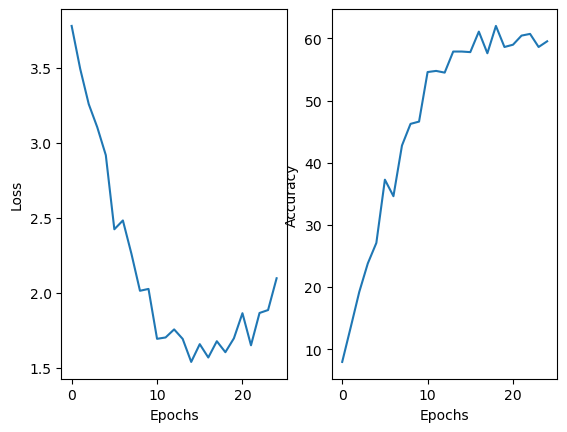

In [144]:
import matplotlib.pyplot as plt

figure, axis = plt.subplots(1, 2)
num_epochs = range(25)
print(total_loss)

axis[0].plot(num_epochs, total_loss)
axis[0].set(xlabel="Epochs", ylabel='Loss')

axis[1].plot(num_epochs, accuracy_over_time)
axis[1].set(xlabel="Epochs", ylabel='Accuracy')

## Convert audio files into wav2vec embeddings ##

In [45]:
features = []

In [46]:
'''
Modified from https://bagustris.wordpress.com/2022/08/23/acoustic-feature-extraction-with-transformers/
'''

from transformers import Wav2Vec2Processor, Wav2Vec2Model
import librosa
import torch

# load model
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")

total_keys = len(keys)
curr_key = 1
for file in keys:
# audio file is decoded on the fly
    print(str(curr_key) + "/" + str(total_keys))
    array, fs = librosa.load(file, sr=16000)
    # print(len(array))
    array_init = array
    while array.shape[0] < 720:
        array = np.concatenate([array, array_init])
    print(array.shape)
    input = processor(array.squeeze(), sampling_rate=fs, return_tensors="pt")

    # apply the model to the input array from wav
    with torch.no_grad():
        outputs = model(**input)

    # extract last hidden state, compute average, convert to numpy
    last_hidden_states = outputs.last_hidden_state.squeeze().mean(axis=0).numpy()
    print(f"Hidden state shape: {last_hidden_states.shape}")
    features.append(last_hidden_states)

    curr_key+=1

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


1/5459
(3902,)
Hidden state shape: (768,)
2/5459
(744,)
Hidden state shape: (768,)
3/5459
(836,)
Hidden state shape: (768,)
4/5459
(6409,)
Hidden state shape: (768,)
5/5459
(978,)
Hidden state shape: (768,)
6/5459
(3228,)
Hidden state shape: (768,)
7/5459
(743,)
Hidden state shape: (768,)
8/5459
(1394,)
Hidden state shape: (768,)
9/5459
(884,)
Hidden state shape: (768,)
10/5459
(790,)
Hidden state shape: (768,)
11/5459
(929,)
Hidden state shape: (768,)
12/5459
(2253,)
Hidden state shape: (768,)
13/5459
(2114,)
Hidden state shape: (768,)
14/5459
(2346,)
Hidden state shape: (768,)
15/5459
(744,)
Hidden state shape: (768,)
16/5459
(1394,)
Hidden state shape: (768,)
17/5459
(836,)
Hidden state shape: (768,)
18/5459
(1302,)
Hidden state shape: (768,)
19/5459
(930,)
Hidden state shape: (768,)
20/5459
(1301,)
Hidden state shape: (768,)
21/5459
(1394,)
Hidden state shape: (768,)
22/5459
(1765,)
Hidden state shape: (768,)
23/5459
(1301,)
Hidden state shape: (768,)
24/5459
(929,)
Hidden state sh

Pickle the datapoint list

In [48]:
# print(features.shape)
with open('./pickles/datapoints.pkl', 'wb') as fp:
    pickle.dump(features, fp)
    print("Pickle Successful")

Pickle Successful


Load datapoint list

In [50]:
with open('./pickles/datapoints.pkl', 'rb') as fp:
    features = pickle.load(fp)
    print("Pickle loaded")

# print(features.shape)
features = np.array(features)
features = torch.from_numpy(features).unsqueeze(1)
print(features.shape)

Pickle loaded
torch.Size([5459, 1, 768])


Testing that datset creates properly

In [53]:
# features = np.array(features)
# features = torch.from_numpy(features).unsqueeze(1)
# print(features.shape)
test = SimpleDataset(features, one_hot_labels)
test_loader = DataLoader(test, batch_size=5, shuffle=True)

data, label = next(iter(test_loader))
print(data.shape)

torch.Size([5, 1, 768])


## Creating and Training model for Text-to-speech embeddings ##

In [54]:
# import sys
# import os
# import glob
# import pandas as pd
# import soundfile as sf
import numpy as np
import pickle
# from sklearn import preprocessing
# from transformers import Wav2Vec2Processor, Wav2Vec2Model
# import librosa
import torch
from torch.utils.data import DataLoader
from Datasets.SimpleDataset import SimpleDataset
# import torch.nn.functional as F
from torch.utils.data import random_split
import torch.nn as nn

In [74]:
labels_int = None
features = None

with open('./pickles/labels_int.pkl', 'rb') as fp:
    labels_int = pickle.load(fp)
    print("Pickle loaded")

with open('./pickles/datapoints.pkl', 'rb') as fp:
    features = pickle.load(fp)
    print("Pickle loaded")

features = np.array(features)
features = np.pad(features, ((0, 0), (0, 16)))
features = np.array(np.split(features, 28, axis=1))
features = features.reshape((features.shape[1], features.shape[0], -1))
print(features.shape)
features = torch.from_numpy(features).unsqueeze(1)
features = features.repeat(1, 3, 1, 1)
print(features.shape)

Pickle loaded
Pickle loaded
(5459, 28, 28)
torch.Size([5459, 3, 28, 28])


In [75]:
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

True
cuda


In [141]:
from model.Mod_Resnet import Mod_Resnet

# model = ResNet1D(1, 2, 3, 1, 1, 8, 59).to(device)
model = Mod_Resnet().to(device)
model.fc = nn.Linear(512, 59) # assuming that the fc7 layer has 512 neurons, otherwise change it 
model.cuda()
print(model)

Using cache found in C:\Users\Thats/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\Thats\miniconda3\envs\ani\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Thats\miniconda3\envs\ani\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Mod_Resnet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [142]:
# print(type(labels_int))
bird_call_dataset = SimpleDataset(features, labels_int)
train_size = int(0.8*len(bird_call_dataset))
test_size = len(bird_call_dataset) - train_size
train_set, test_set = random_split(bird_call_dataset, [train_size, test_size])

train_dataloader = DataLoader(train_set, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=True)

In [143]:
loss_fn = nn.CrossEntropyLoss()
# Try different learning rate
learning_rate = 0.01

# Try different optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [144]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        y = y.type(torch.LongTensor)
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        # print(X.shape)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [145]:
total_loss = []
accuracy_over_time = []
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            y = y.type(torch.LongTensor)
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    total_loss.append(test_loss)
    correct /= size
    accuracy_over_time.append(100*correct)
    print(f"Valid Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [146]:
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 7.082759  [    0/ 4367]
loss: 4.821907  [ 1600/ 4367]
loss: 4.320475  [ 3200/ 4367]
Valid Error: 
 Accuracy: 6.0%, Avg loss: 4.238630 

Epoch 2
-------------------------------
loss: 3.838241  [    0/ 4367]
loss: 4.264955  [ 1600/ 4367]
loss: 3.714820  [ 3200/ 4367]
Valid Error: 
 Accuracy: 7.2%, Avg loss: 4.154805 

Epoch 3
-------------------------------
loss: 3.795330  [    0/ 4367]
loss: 3.701960  [ 1600/ 4367]
loss: 3.952955  [ 3200/ 4367]
Valid Error: 
 Accuracy: 10.1%, Avg loss: 3.991977 

Epoch 4
-------------------------------
loss: 3.997535  [    0/ 4367]
loss: 3.679966  [ 1600/ 4367]
loss: 3.907989  [ 3200/ 4367]
Valid Error: 
 Accuracy: 11.3%, Avg loss: 3.854800 

Epoch 5
-------------------------------
loss: 3.691536  [    0/ 4367]
loss: 4.439441  [ 1600/ 4367]
loss: 3.116179  [ 3200/ 4367]
Valid Error: 
 Accuracy: 12.0%, Avg loss: 3.887095 

Epoch 6
-------------------------------
loss: 3.568847  [    0/ 4367]
loss: 3.547835  [

[4.238630308621172, 4.154804602913234, 3.991976744886758, 3.854799833850584, 3.8870953165966533, 3.676690619924794, 3.596649494723997, 3.6321536077969316, 3.762304876161658, 3.6409838026848393, 3.9260169975999473, 3.45094206713248, 3.5893682880678037, 3.6335320991018545, 3.3969168144723643, 3.4836757632269375, 3.441189275271651, 3.4388712454533232, 3.447519416394441, 3.4325903256734214, 3.3833266617595283, 3.423612408016039, 3.4455622244572295, 3.4471131787783857, 3.4124280438906904, 3.444240041401075, 3.3953515723131704, 3.429596776547639, 3.4668088132056636, 3.498319390891255, 3.445954734000607, 3.4921225844949917, 3.5209715400916943, 3.527608681416166, 3.5366176556849824, 3.5780807508938555, 3.578498363494873, 3.5079299470652705, 3.6091311185256294, 3.6381261141403862, 3.696361904558928, 3.6761210137519282, 3.6906866992729297, 3.858749586602916, 3.8026743937229766, 3.8915757960167485, 4.010188434434974, 4.1767715785814366, 4.167511711949888, 4.150991232498832, 4.204946248427682, 4.2

[Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'Accuracy')]

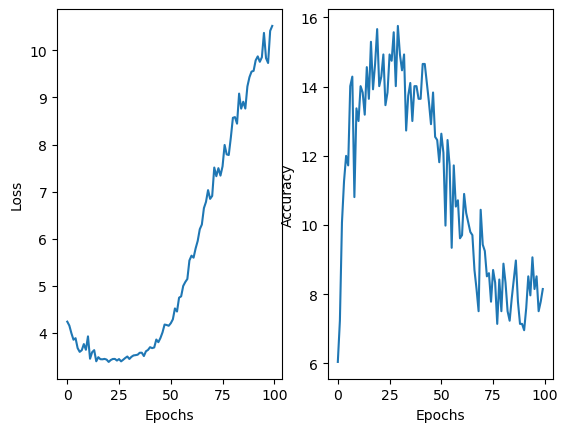

In [147]:
import matplotlib.pyplot as plt

figure, axis = plt.subplots(1, 2)
num_epochs = range(100)
print(total_loss)

axis[0].plot(num_epochs, total_loss)
axis[0].set(xlabel="Epochs", ylabel='Loss')

axis[1].plot(num_epochs, accuracy_over_time)
axis[1].set(xlabel="Epochs", ylabel='Accuracy')